In [2]:
import os
import numpy as np
import pandas as pd
import random
import rapidfuzz
# functions for reading data from codenet:
import codenet_reader

In [3]:
# Functions for processing solutions of a problem


def pair_series(sr_x, sr_y, n_pairs, col_x: str, col_y: str) -> pd.DataFrame:
    assert len(sr_x) == len(sr_y)
    n_rows = len(sr_x)
    if n_rows < 2 * n_pairs:
        raise ValueError("Too many pairs.")
    inds = np.random.choice(n_rows, size=2 * n_pairs, replace=False)
    inds_x, inds_y = inds[:n_pairs], inds[n_pairs:]
    pairs = [
        (sr_x.iloc[i], sr_y.iloc[j]) for i,j in zip(inds_x,inds_y)
    ]
    return pd.DataFrame(pairs, columns=[f'{col_x}_x', f'{col_y}_y'])


def process_pid(pid: str, ac_data_map: dict, re_data_map: dict):
    MIN_PAIRS = 1
    
    num_python_solutions = len(codenet_reader.python_solutions(pid))
    if num_python_solutions <= 5:
        return
    
    df = codenet_reader.init_metadata_df(pid)
    if df is None:
        return
    
    df_accepted = df.loc['Accepted'== df['status']]
    df_rejected = df.loc['Accepted'!= df['status']]
    
    print(f'{pid}','-'*50)
    print(' accepted:', df_accepted.shape[0])
    print(' rejected:', df_rejected.shape[0])
    
    n_rows = min(df_accepted.shape[0], df_rejected.shape[0])
    if n_rows < 2 * MIN_PAIRS:
        return
    
    df_accepted = df_accepted['submission_id']
    df_accepted = df_accepted.iloc[:n_rows]
    df_pp = pair_series(df_accepted, df_accepted, n_rows//2, 'sid', 'sid')
    
    df_rejected = df_rejected['submission_id']
    df_rejected = df_rejected.iloc[:n_rows]
    df_np = pair_series(df_accepted, df_rejected, n_rows//2, 'sid', 'sid')
    
    def create_pair(pid, sid_x, sid_y, label: int):
        return {
            "pid"  : pid,
            "sid_x": sid_x,
            "sid_y": sid_y,
            "src_x": codenet_reader.read_solution_file(pid, sid_x),
            "src_y": codenet_reader.read_solution_file(pid, sid_y),
            "label": label
        }
    
    if n_positive_pairs := df_pp.shape[0]:
        ssize = n_positive_pairs//2
        ac_rows = [tuple(row) for _, row in df_pp.sample(ssize).iterrows()]
        ac_data_map[pid] = [
            create_pair(pid, sid_x, sid_y, label=1)
            for sid_x, sid_y in ac_rows
        ]

    if n_negative_pairs := df_np.shape[0]:
        ssize = n_negative_pairs//2
        re_rows = [tuple(row) for _, row in df_np.sample(ssize).iterrows()]
        re_data_map[pid] = [
            create_pair(pid, sid_x, sid_y, label=0)
            for sid_x, sid_y in re_rows
        ]


def test():
    process_pid('p03200', {}, {})

In [4]:
test()

p03200 --------------------------------------------------
 accepted: 612
 rejected: 333


In [ ]:
# Reading data

SAMPLE_SIZE = 2000

_pids = os.listdir(codenet_reader.DATA_PATH)
_pids = random.sample(_pids, k=min(SAMPLE_SIZE, len(_pids)))

ac_data = {}
re_data = {}

print('Starting...')
print(f'Processing {len(_pids)} problems.')

for _pid in _pids:
    process_pid(_pid, ac_data, re_data)

print('Data gathered...')

pp_output = []
np_output = []
for pid in ac_data:
    for data in ac_data[pid]:
        pp_output.append((pid,
            data['sid_x'], data['sid_y'],
            data['src_x'], data['src_y'],
            data['label'],))
for pid in re_data:
    for data in re_data[pid]:
        np_output.append((pid,
            data['sid_x'], data['sid_y'],
            data['src_x'], data['src_y'],
            data['label'],))

print(f'POSITIVE pairs created... LENGTH: {len(pp_output)}')
print(f'NEGATIVE pairs created... LENGTH: {len(np_output)}')

pp_output = list(sorted(set(pp_output), key = lambda x:(x[0],x[1])))
np_output = list(sorted(set(np_output), key = lambda x:(x[0],x[1])))

pp_len, np_len = len(pp_output), len(np_output)

print(f'POSITIVE pair content filtered... LENGTH: {pp_len}')
print(f'NEGATIVE pair content filtered... LENGTH: {np_len}')

print('DONE')

columns = ['pid','sid_x', 'sid_y', 'src_x', 'src_y', 'label']
# positive pairs
pp_output = pd.DataFrame(pp_output, columns=columns)
# negative pairs
np_output = pd.DataFrame(np_output, columns=columns)

In [5]:
# Calculating rapid fuzz

def run_rf(a,b): return rapidfuzz.fuzz.ratio(a,b)

pp_output['rf_ratio'] = pp_output.apply(lambda row: run_rf(row['src_x'], row['src_y']), axis=1)
np_output['rf_ratio'] = np_output.apply(lambda row: run_rf(row['src_x'], row['src_y']), axis=1)

In [6]:
# Rapid fuzz counts
print('pp gt 80%:', (pp_output['rf_ratio']>80).sum())
print('np gt 80%:', (np_output['rf_ratio']>80).sum())

pp gt 80%: 2817
np gt 80%: 1345


Text(0.5, 0, 'rf ratio on positive pairs')

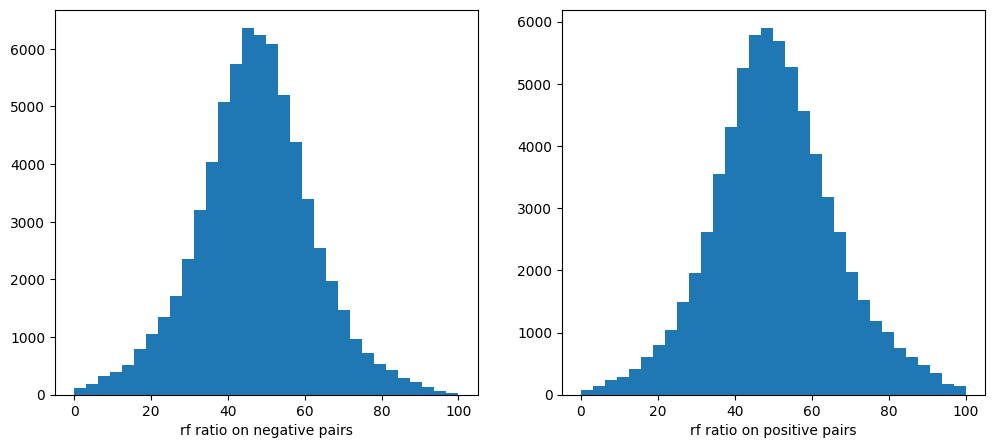

In [7]:
# Rapid fuzz histograms
import matplotlib.pyplot as plt
res = 32
# histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].hist(np_output['rf_ratio'], bins=res)
ax[0].set_xlabel('rf ratio on negative pairs')
ax[1].hist(pp_output['rf_ratio'], bins=res)
ax[1].set_xlabel('rf ratio on positive pairs')

In [8]:
# Filtering and sampling
pp_output = pp_output.sample(5000)
#np_output = np_output[np_output['rf_ratio'] > 80]
np_output = np_output.sample(5000)

In [9]:
# Exporting
EXPORTED_FILE_NAME = 'output_paired.csv'
pp_output = pp_output[columns]
np_output = np_output[columns]
output = pd.concat([pp_output, np_output], ignore_index=True)
output.to_csv(EXPORTED_FILE_NAME)

In [10]:
df = pd.read_csv(EXPORTED_FILE_NAME)
len(set(df['pid']))

504